In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import Figure_H2H_Regret

from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

In [2]:
import Baseline_Params 
import Sequential_Learning_Approaches as SLA
import Integrated_Learning_Approaches as ILA

## Parameters

In [3]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))
middle_path = '/Data_JOC_R1/Shortest_Path_0620/Baseline_' + data_generation_process +"/"
working_dir = project_directory + middle_path
Result_dir = project_directory + middle_path + "Result/"
pathlib.Path(working_dir).mkdir(parents=True, exist_ok=True)
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

In [4]:
# Baseline_Params.set_Params(working_dir)
num_train, num_feat, num_test, deg, e, lower, upper, p, alpha, mis, coef_seed, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump, grid_all, iteration_all,mu_all, lamb_all = Baseline_Params.get_Params(working_dir)

In [5]:
num_train = 300
grid_all = [(2, 2), (3, 3), (4, 4)]

#### Impact of network size

In [6]:
h2h_ddr_vs_ols_ante = {}; cost_rd_ddr_vs_ols_ante = {}; regret_rd_ddr_vs_ols_ante = {}
for grid in grid_all:
    L_N = grid[0]
    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
    DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)     
    cost_Oracle_Ante_all,cost_OLS_Ante_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    for mu in mu_all:
        for lamb in lamb_all:
            h2h_ddr_vs_ols_ante[L_N,mu,lamb],regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] \
                = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    print("Grid = ",grid)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path_0620/Baseline_SPO_Data_Generation/2by2_grid/data_size=300_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (2, 2)
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path_0620/Baseline_SPO_Data_Generation/3by3_grid/data_size=300_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (3, 3)
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path_0620/Baseline_SPO_Data_Generation/4by4_grid/data_size=300_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (4, 4)


In [7]:
def obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_input,regret_rd_ddr_vs_ols_input):
    h2h_avg_all = {}; regret_rd_avg_all = {}
    h2h_prop_all = {}; regret_rd_prop_all = {}

    for grid in grid_all:
        L_N = grid[0]
        h2h_avg = np.zeros((len(mu_all),len(lamb_all))); regret_rd_avg = np.zeros((len(mu_all),len(lamb_all)))
        h2h_prop = np.zeros((len(mu_all),len(lamb_all))); regret_rd_prop = np.zeros((len(mu_all),len(lamb_all)))

        mu_index = 0
        for mu in mu_all:
            lamb_index = 0
            for lamb in lamb_all:
                h2h_ddr_ols_tem = h2h_ddr_vs_ols_input[L_N,mu,lamb]
                regret_rd_ddr_vs_ols_tem = regret_rd_ddr_vs_ols_input[L_N,mu,lamb]

                h2h_avg[mu_index,lamb_index] = np.nanmean(h2h_ddr_ols_tem)
                regret_rd_avg[mu_index,lamb_index] = np.nanmean(regret_rd_ddr_vs_ols_tem)
                
                h2h_prop[mu_index,lamb_index] = len(h2h_ddr_ols_tem[h2h_ddr_ols_tem >= 0.5])/len(h2h_ddr_ols_tem)
                regret_rd_prop[mu_index,lamb_index] = len(regret_rd_ddr_vs_ols_tem[regret_rd_ddr_vs_ols_tem > 0.0])/len(regret_rd_ddr_vs_ols_tem)
        
                lamb_index = lamb_index + 1
            mu_index = mu_index + 1

        h2h_avg_all[L_N] = h2h_avg
        regret_rd_avg_all[L_N] = regret_rd_avg
        h2h_prop_all[L_N] = h2h_prop
        regret_rd_prop_all[L_N] = regret_rd_prop

    return h2h_avg_all,regret_rd_avg_all,h2h_prop_all,regret_rd_prop_all

In [8]:
h2h_ddr_vs_ols_ante_avg_all,regret_rd_ddr_vs_ols_ante_avg_all,h2h_ddr_vs_ols_ante_prop_all,regret_rd_ddr_vs_ols_ante_prop_all = \
    obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_ante,regret_rd_ddr_vs_ols_ante)

In [9]:
regret_avg_max_ante = np.zeros(len(grid_all)); regret_avg_max_indices_ante = {}
regret_prop_max_ante = np.zeros(len(grid_all)); regret_prop_max_indices_ante = {}

grid_index = 0
for grid in grid_all:
    L_N = grid[0]

    regret_avg_max_ante[grid_index] = np.max(regret_rd_ddr_vs_ols_ante_avg_all[L_N]) * 100
    max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_ante_avg_all[L_N]), regret_rd_ddr_vs_ols_ante_avg_all[L_N].shape)
    regret_avg_max_indices_ante[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    regret_prop_max_ante[grid_index] = np.max(regret_rd_ddr_vs_ols_ante_prop_all[L_N]) * 100
    max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_ante_prop_all[L_N]), regret_rd_ddr_vs_ols_ante_prop_all[L_N].shape)
    regret_prop_max_indices_ante[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    grid_index = grid_index + 1

In [10]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import seaborn as sns
import matplotlib.pyplot as plt

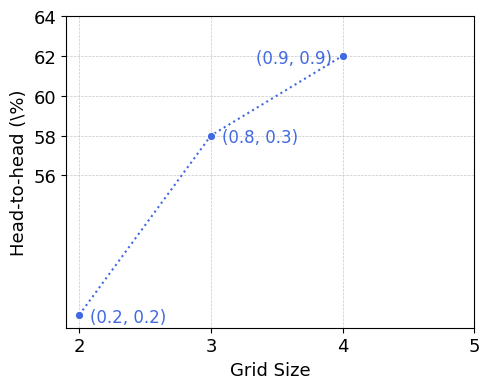

In [11]:
ticksize = 13
labelsize = 13
legendsize = 13

grid_sizes = [grid[0] for grid in grid_all]

plt.figure(figsize=(5, 4))
sns.set_palette("tab10")  # Enhanced color palette
custom_colors = ['#D93B3C', 'royalblue', '#4F207F', '#EFAB02']
markers = ["o","X","s","d"]

sns.lineplot(x=grid_sizes, y=regret_prop_max_ante,marker=markers[0], color=custom_colors[1], linestyle=':')

# plt.title('Change of Values by Sample Size and Varphi')
plt.xlabel('Grid Size', fontsize = labelsize)
plt.ylabel('Head-to-head (\%)', fontsize = labelsize)

xytext_psotion = [(35, -5),(35, -5),(-35, -5),(-15, -20)]
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = regret_prop_max_indices_ante[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, regret_prop_max_ante[i]),
                 textcoords="offset points",
                 xytext=xytext_psotion[i],
                 ha='center',
                 fontsize=12,
                 color=custom_colors[1])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks([2, 3, 4, 5], fontsize=ticksize)
plt.yticks(np.arange(56,66,2), fontsize=ticksize)

plt.tight_layout()  # Automatically adjust subplot params to give specified padding
plt.savefig(Result_dir +"Impact_Network_Structure_Ante_on_H2H.pdf", format='pdf')

plt.show()

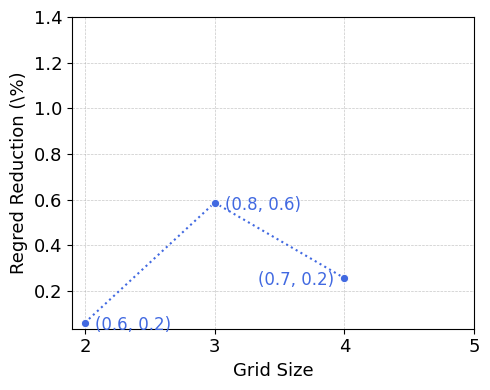

In [12]:
ticksize = 13
labelsize = 13
legendsize = 13
grid_sizes = [grid[0] for grid in grid_all]

plt.figure(figsize=(5, 4))
sns.set_palette("tab10")  # Enhanced color palette
custom_colors = ['#D93B3C', 'royalblue', '#4F207F', '#EFAB02']
markers = ["o","X","s","d"]

sns.lineplot(x=grid_sizes, y=regret_avg_max_ante,marker=markers[0], color=custom_colors[1], linestyle=':')

# plt.title('Change of Values by Sample Size and Varphi')
plt.xlabel('Grid Size', fontsize = labelsize)
plt.ylabel('Regred Reduction (\%)', fontsize = labelsize)

xytext_psotion = [(35, -5),(35, -5),(-35, -5),(-15, -20)]
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = regret_avg_max_indices_ante[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, regret_avg_max_ante[i]),
                 textcoords="offset points",
                 xytext=xytext_psotion[i],
                 ha='center',
                 fontsize=12,
                 color=custom_colors[1])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks([2, 3, 4,5], fontsize=ticksize)
plt.yticks([0.2, 0.4, 0.6,0.8,1.0,1.2,1.4], fontsize=ticksize)

plt.tight_layout()  # Automatically adjust subplot params to give specified padding
plt.savefig(Result_dir +"Impact_Network_Structure_Ante_on_Regret_Rd.pdf", format='pdf')

plt.show()